In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
import pickle
from tensorflow.keras.models import load_model
import os

<h2> Điền thông tin

In [13]:
# Điền thời gian 
minute_input = 10
minute_output = 10

# Chọn kiểu model muốn load. Nếu là Deep Learning điền DL, nếu là Machine Learning điền ML
hastag = "DL"
#hastag = "ML"

# Điền tên loại model
# Gồm có: LSTM, CNN, KNN, RANDOM FOREST, DECISION TREE, LOGISTIC REGRESSION, NAIVEBAYES, GradientBoosting
model_name = "SVM"

# Điền đường dẫn của mô hình DL
model_path = "D:/UIT/NCKHSV/Năm 2023/File model/trained/LSTM_PastECG_FutureCls_10-mininput_10-minoutput.h5"
# Điền đường dẫn của mô hình ML
#model_path = "D:/UIT/NCKHSV/Năm 2023/File model/trained/SVM_PastECG_FutureCls_10-mininput_10-minoutput"

# Điền đường dẫn data
data_path = './Test/'

# Điền đường dẫn thư mục lưu trữ kết quả
result_folder = "./Result/"

<h2> Configuration

In [14]:
window_input= 40*minute_input
window_out= 40*minute_input
train_size = 0.8
test_size = 1 - train_size
# data_set = {
#   0: "test",
#   1: "train"
# }

data_set = {
  0: "test_ram",
  1: "train_ram"
}

# length_ecg là độ dài 2 khoảng RR được fixed lúc tiền xử lý dữ liệu 
# (độ dài một dòng trong file excel, trừ cột cuối là nhãn lớp bệnh tim)
length_ecg = 187 
batch_size = 16
# model_cls = "LSTM"
'''
Độ dài của input/output càng dài thì số lượng file không đáp ứng đủ để tạo một mẫu hợp lệ 
cho mô hình càng nhiều. Để đám bảo tính thống nhất nên sẽ dùng độ dài dài nhất của phần 
input/output trong quá trình thực nghiệm để là chuẩn từ đó loại các file bị thiếu này đều
ở những phần thực nghiệm input/output khác.
'''
missing_file_train = ['201_V1.csv', '102_V2.csv', '124_V4.csv', '112_V1.csv', '203_V1.csv', '116_V1.csv', '108_V1.csv', '207_V1.csv', '111_V1.csv', '200_V1.csv', '207_MLII.csv', '210_V1.csv', '202_V1.csv', '113_V1.csv', '214_V1.csv', '121_V1.csv', '109_V1.csv', '105_V1.csv', '107_V1.csv', '115_V1.csv', '208_V1.csv']
missing_file_test = ['213_V1.csv', '231_V1.csv', '228_V1.csv', '222_V1.csv', '232_V1.csv']

<h2> Get Data

<h3> Nếu load theo DL chọn hastag = "DL" 
<h3> Nếu load theo ML chọn hastag = "ML"

In [15]:
class Dataset:
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        # read data
        X = self.data[i]
        y = self.label[i].astype(int)
        return X, y

class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size,size):
        self.dataset = dataset
        self.batch_size = batch_size
        self.size= size

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return tuple(batch)

    def __len__(self):
        return self.size //self.batch_size

In [16]:
def get_data(istrainset):
    if hastag == "DL":
        missing_file = []
        total_sample = 0
        directory = f"{data_path}{data_set[istrainset]}/"
        X, y = [], []
        for filename in os.listdir(directory):
            if (filename not in (missing_file_train)) and (filename not in (missing_file_test)) and (filename != ".DS_Store"):
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    df = pd.read_csv(f, header=None)
                    data=df.drop(columns=length_ecg)
                    data=data.values
                    data1=df.iloc[:, length_ecg]
                    # Số lượng lặp qua dữ liệu
                    num_samples = len(data) - window_input - window_out
                    # Tạo dữ liệu train từ cửa sổ trượt
                    if num_samples > 0:
                        total_sample = total_sample + num_samples
                        for i in range(num_samples):
                            X_window = data[i:i+window_input]
                            y_value = data1[i+window_input+window_out]

                            X.append(X_window)
                            y.append(y_value)
                    else:
                        missing_file.append(filename)
        print("------🍒------")
        print(f"Num of file in {data_set[istrainset]} set can not use due to its missing of length: {len(missing_file)}")
        print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
        print(f"Missing files: {missing_file}")
        
    if hastag == "ML":
        missing_file = []
        total_sample = 0
        directory = f"{data_path}{data_set[istrainset]}/"
        X, y = [], []
        for filename in os.listdir(directory):
            if (filename not in (missing_file_train)) and (filename not in (missing_file_test)) and (filename != ".DS_Store"):
                f = os.path.join(directory, filename)
                if os.path.isfile(f):
                    df = pd.read_csv(f, header=None)
                    data=df.drop(columns=length_ecg)
                    data=data.values
                    data1=df.iloc[:, length_ecg]
                    # Số lượng lặp qua dữ liệu
                    num_samples = len(data) - window_input - window_out
                    # Tạo dữ liệu train từ cửa sổ trượt
                    if num_samples > 0:
                        total_sample = total_sample + num_samples
                        for i in range(num_samples):
                            X_window = data[i:i+window_input]
                            y_value = data1[i+window_input+window_out]

                            X.append(X_window.reshape(window_input*length_ecg))
                            y.append(y_value)
                    else:
                        missing_file.append(filename)
        print("------🍒------")
        print(f"Num of file in {data_set[istrainset]} set can not use due to its missing of length: {len(missing_file)}")
        print(f"Number of sample: {len(y)}/{len(X)}/{total_sample}")
        print(f"Missing files: {missing_file}")
    return X, y

<h2> Load Data

In [17]:
# Lấy tập train/test
X_train, y_train = get_data(1)
X_test, y_test = get_data(0)

------🍒------
Num of file in train_ram set can not use due to its missing of length: 0
Number of sample: 2646/2646/2646
Missing files: []
------🍒------
Num of file in test_ram set can not use due to its missing of length: 0
Number of sample: 2442/2442/2442
Missing files: []


In [18]:
if hastag == "DL":
    train_dataset = Dataset(X_train, y_train)
    test_dataset = Dataset(X_test, y_test)

    train_loader = Dataloader(train_dataset, batch_size,len(train_dataset))
    test_loader = Dataloader(test_dataset,batch_size,len(test_dataset))

<h2> Load Model

In [19]:
if hastag == "DL":
    # Tải mô hình DL từ tệp
    model = load_model(model_path)
    # Sử dụng mô hình đã tải
    predictions = model.predict(test_loader)
    y_pred = np.argmax(predictions, axis=1)

    # Lấy độ dài y_test bằng y_pred
    x = len(y_test) - len(y_pred)
    y = len(y_test) - x
    y_test = y_test[:y]

else:
    # Tải mô hình ML từ tệp
    model = joblib.load(model_path)

    # Sử dụng mô hình đã tải
    y_pred = model.predict(X_test)

152/152 [==============================] - 13s 79ms/step


<h2> Save đánh giá

In [20]:
report = classification_report(y_test, y_pred)
print(report)

#Save
# Dùng classification_report để tính các độ đo
report = classification_report(y_test, y_pred, output_dict=True)

# Chuyển đổi báo cáo thành DataFrame
df = pd.DataFrame(report).transpose()

# Chọn các cột quan trọng như F1, accuracy, precision và recall
selected_columns = ['precision', 'recall', 'f1-score', 'support']
df_selected = df[selected_columns]

# Đường dẫn tệp CSV đích
csv_path = f"{result_folder}/{model_name}_{minute_input}_{minute_output}.csv"

# Lưu DataFrame vào tệp CSV
df_selected.to_csv(csv_path, index=True)

              precision    recall  f1-score   support

         0.0       0.37      1.00      0.54       907
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00        51
         3.0       0.00      0.00      0.00       156
         4.0       0.00      0.00      0.00      1316

    accuracy                           0.37      2432
   macro avg       0.07      0.20      0.11      2432
weighted avg       0.14      0.37      0.20      2432



c:\Users\MSI GAMING\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI GAMING\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\MSI GAMING\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

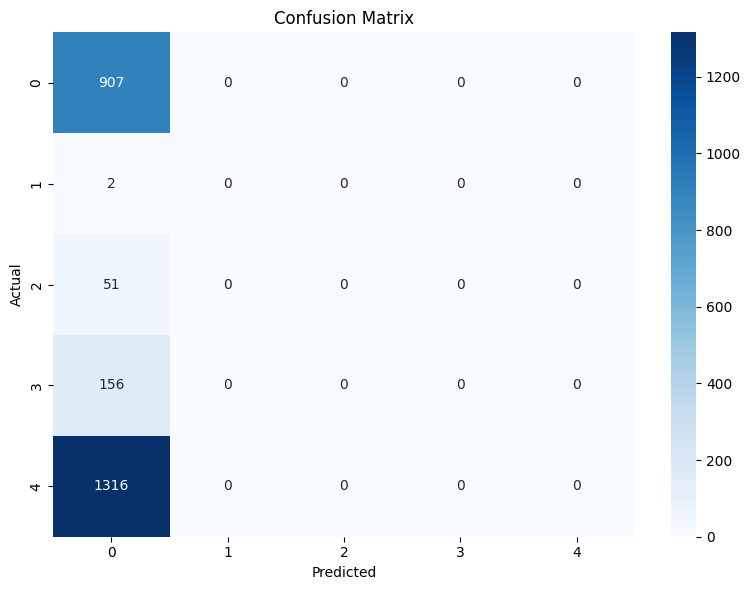

In [21]:
# Tính ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)

# Tạo biểu đồ dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()

# Đường dẫn tệp hình ảnh đích
image_path = f"{result_folder}/{model_name}_{minute_input}_{minute_output}_confusion_matrix.png"

# Lưu ma trận nhầm lẫn thành hình ảnh
plt.savefig(image_path)

# Hiển thị biểu đồ
plt.show()

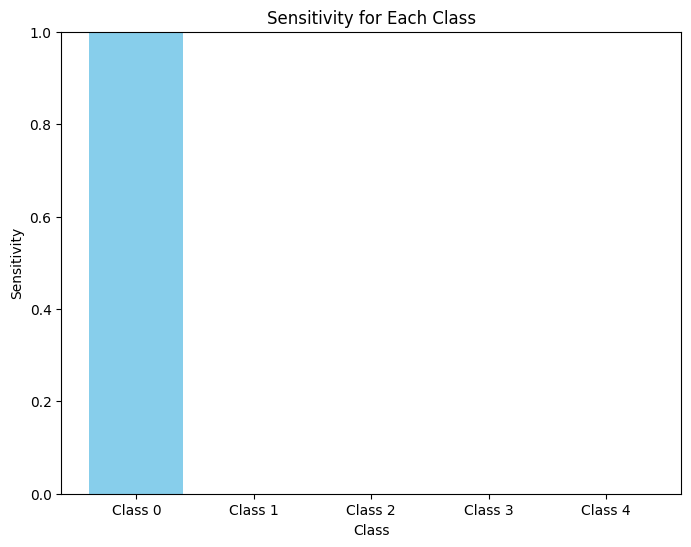

<Figure size 640x480 with 0 Axes>

In [22]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# Tính độ nhạy cho từng lớp
sensitivity_scores = recall_score(y_test, y_pred, average=None)

# Tên của các lớp
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
plt.bar(class_names, sensitivity_scores, color='skyblue')
plt.title('Sensitivity for Each Class')
plt.xlabel('Class')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)  
# Hiển thị biểu đồ
plt.show()

# Đường dẫn tệp hình ảnh đích
image_path = f"{result_folder}/{model_name}_{minute_input}_{minute_output}_sensitivity_chart.png"

# Lưu biểu đồ độ nhạy thành hình ảnh
plt.savefig(image_path)